# Wrangling WeRateDogs (@dog_rates) Twitter Data
## By Nicholas Holgate

### Project Motivation

The goal is to wrangle WeRateDogs (@dog_rates) Twitter data to create interesting and trustworthy analyses and visualizations. For this project, not only the WeRateDogs Twitter archive dating back to 1st August 2017 is to be used, but also additional data including retweet counts and favourite counts, as well as an image classification of the dogs referred to in the tweets.

## Table of Contents
- [Gathering Data](#gath)
- [Assessing Data](#ass)
- [Cleaning Data](#clean)
- [Storing Data](#store)
- [Analysing Data](#anal)

### Importing Python libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import io
import IPython.display as Disp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

<a id='gath'></a>
### Gathering Data

There are three pieces of data to utilise in this project.

#### WeRateDogs Twitter archive

The Twitter archive was provided by the requester by CSV file:

In [2]:
# Load CSV file into Pandas dataframe
pd.set_option('display.max_colwidth', -1)
twit = pd.read_csv('twitter-archive-enhanced.csv')
twit.head(5)

C:\Apps\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193 NaN                    NaN                    
1  892177421306343426 NaN                    NaN                    
2  891815181378084864 NaN                    NaN                    
3  891689557279858688 NaN                    NaN                    
4  891327558926688256 NaN                    NaN                    

                   timestamp  \
0  2017-08-01 16:23:56 +0000   
1  2017-08-01 00:17:27 +0000   
2  2017-07-31 00:18:03 +0000   
3  2017-07-30 15:58:51 +0000   
4  2017-07-29 16:00:24 +0000   

                                                                               source  \
0  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
3  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
4  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                                                 text  \
0  This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU                                                        
1  This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV   
2  This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB                    
3  This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ                                                              
4  This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f   

   retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
0 NaN                  NaN                        NaN                         
1 NaN                  NaN                        NaN                         
2 NaN                  NaN                        NaN                         
3 NaN                  NaN                        NaN                         
4 NaN                  NaN                        NaN                         

                                                                                                                     expanded_urls  \
0  https://twitter.com/dog_rates/status/892420643555336193/photo/1                                                                   
1  https://twitter.com/dog_rates/status/892177421306343426/photo/1                                                                   
2  https://twitter.com/dog_rates/status/891815181378084864/photo/1                                                                   
3  https://twitter.com/dog_rates/status/891689557279858688/photo/1                                                                   
4  https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1   

   rating_numerator  rating_denominator      name doggo floofer pupper puppo  
0  13                10                  Phineas   None  None    None   None  
1  13                10                  Tilly     None  None    None   None  
2  12                10                  Archie    None  None    None   None  
3  13                10                  Darla     None  None    None   None  
4  12                10                  Franklin  None  None    None   None

#### Tweet image classification

The file (image_predictions.tsv) was created by the requester but is hosted on Udacity's servers. It will be downloaded using the Requests library:

In [3]:
# Request data through URL provided
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)

# Format data requested into file
with open('image_predictions.tsv', 'wb') as file:
    file.write(r.content)

# Read TSV file into Pandas dataframe    
imgclass = pd.read_csv('image_predictions.tsv', sep='\t')
imgclass.head(5)

tweet_id                                          jpg_url  \
0  666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1  666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2  666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3  666044226329800704  https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4  666049248165822465  https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   

   img_num                      p1   p1_conf  p1_dog                  p2  \
0  1        Welsh_springer_spaniel  0.465074  True    collie               
1  1        redbone                 0.506826  True    miniature_pinscher   
2  1        German_shepherd         0.596461  True    malinois             
3  1        Rhodesian_ridgeback     0.408143  True    redbone              
4  1        miniature_pinscher      0.560311  True    Rottweiler           

    p2_conf  p2_dog                   p3   p3_conf  p3_dog  
0  0.156665  True    Shetland_sheepdog    0.061428  True    
1  0.074192  True    Rhodesian_ridgeback  0.072010  True    
2  0.138584  True    bloodhound           0.116197  True    
3  0.360687  True    miniature_pinscher   0.222752  True    
4  0.243682  True    Doberman             0.154629  True

#### WeRateDogs Twitter JSON data

Using the tweet IDs in the WeRateDogs Twitter archive, the Twitter API will be queried for each tweet's JSON data using Python's Tweepy library. Each WeRateDogs tweet's retweet count and favourite count will be collated:

In [4]:
# Create a list from JSON text file
d = []
with open('tweet-json.txt') as t:
    for line in t:
        d.append(json.loads(line))

# Create Pandas dataframe from list
twit_inf = pd.DataFrame()
twit_inf['tweet_id'] = list(map(lambda tweet: tweet['id'], d))
twit_inf['retweet_count'] = list(map(lambda tweet: tweet['retweet_count'], d))
twit_inf['favorite_count'] = list(map(lambda tweet: tweet['favorite_count'], d))
twit_inf.head(5)

tweet_id  retweet_count  favorite_count
0  892420643555336193  8853           39467         
1  892177421306343426  6514           33819         
2  891815181378084864  4328           25461         
3  891689557279858688  8964           42908         
4  891327558926688256  9774           41048

<a id='ass'></a>
### Assessing Data

The data is assessed visually and programmatically for quality and tidiness issues. Eight quality issues and two tidiness issues will be detected and documented.

#### WeRateDogs Twitter archive

In [5]:
# View all data
pd.set_option('display.max_rows', None)
twit

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0     892420643555336193 NaN                    NaN                    
1     892177421306343426 NaN                    NaN                    
2     891815181378084864 NaN                    NaN                    
3     891689557279858688 NaN                    NaN                    
4     891327558926688256 NaN                    NaN                    
5     891087950875897856 NaN                    NaN                    
6     890971913173991426 NaN                    NaN                    
7     890729181411237888 NaN                    NaN                    
8     890609185150312448 NaN                    NaN                    
9     890240255349198849 NaN                    NaN                    
10    890006608113172480 NaN                    NaN                    
11    889880896479866881 NaN                    NaN                    
12    889665388333682689 NaN                    NaN                    
13    889638837579907072 NaN                    NaN                    
14    889531135344209921 NaN                    NaN                    
15    889278841981685760 NaN                    NaN                    
16    888917238123831296 NaN                    NaN                    
17    888804989199671297 NaN                    NaN                    
18    888554962724278272 NaN                    NaN                    
19    888202515573088257 NaN                    NaN                    
20    888078434458587136 NaN                    NaN                    
21    887705289381826560 NaN                    NaN                    
22    887517139158093824 NaN                    NaN                    
23    887473957103951883 NaN                    NaN                    
24    887343217045368832 NaN                    NaN                    
25    887101392804085760 NaN                    NaN                    
26    886983233522544640 NaN                    NaN                    
27    886736880519319552 NaN                    NaN                    
28    886680336477933568 NaN                    NaN                    
29    886366144734445568 NaN                    NaN                    
30    886267009285017600  8.862664e+17           2.281182e+09          
31    886258384151887873 NaN                    NaN                    
32    886054160059072513 NaN                    NaN                    
33    885984800019947520 NaN                    NaN                    
34    885528943205470208 NaN                    NaN                    
35    885518971528720385 NaN                    NaN                    
36    885311592912609280 NaN                    NaN                    
37    885167619883638784 NaN                    NaN                    
38    884925521741709313 NaN                    NaN                    
39    884876753390489601 NaN                    NaN                    
40    884562892145688576 NaN                    NaN                    
41    884441805382717440 NaN                    NaN                    
42    884247878851493888 NaN                    NaN                    
43    884162670584377345 NaN                    NaN                    
44    883838122936631299 NaN                    NaN                    
45    883482846933004288 NaN                    NaN                    
46    883360690899218434 NaN                    NaN                    
47    883117836046086144 NaN                    NaN                    
48    882992080364220416 NaN                    NaN                    
49    882762694511734784 NaN                    NaN                    
50    882627270321602560 NaN                    NaN                    
51    882268110199369728 NaN                    NaN                    
52    882045870035918850 NaN                    NaN                    
53    881906580714921986 NaN                    NaN                    
54    881666595344535552 NaN                    NaN     

In [6]:
# Show information of dataset
twit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

Archive contains 2356 entries and 17 variables.

Only "in_reply" and "retweeted" variables have less than 2356 entries.

WeRateDogs Twitter archive column descriptions:
- **tweet_id**: Unique numerical identifier for each Tweet
- **in_reply_to_status_id**: If the Tweet is a reply, the unique numerical identifier for the original Tweet
- **in_reply_to_user_id**: If the Tweet is a reply, the unique numerical identifier for the original Tweet's author ID
- **timestamp**: Time at which the Tweet was posted
- **source**: Service used for each Tweet e.g. iPhone, webpage etc.
- **text**: Tweet content with up to 280 characters (max)
- **retweeted_status_id**: If the Tweet is a retweet, the unique numerical identifier for the original Tweet
- **retweeted_status_user_id**: If the Tweet is a retweet, the unique numerical identifier for the original Tweet's author ID
- **retweeted_status_timestamp**: Time at which the Tweet was retweeted
- **expanded_urls**: URL for each Tweet
- **rating_numerator**: Dog ratings almost always have a numerator greater than 10 e.g. 11/10, 12/10, 13/10 etc.
- **rating_denominator**: Dog ratings almost always have a denominator of 10.
- **name**: Name of dog
- **doggo**: A "stage" of a dog's life where the dog is "a big pupper"
- **floofer**: A "stage" of a dog's life where the dog has an excess of fur
- **pupper**: A "stage" of a dog's life where the dog is a young "doggo" and small i.e. a pup
- **puppo**: A "stage" of a dog's life where the dog is between a "pupper" and a "doggo" i.e. dog equivalent of a teenager

**Quality Issue #1**: Twitter status_id cannot have a decimal fraction component and therefore should be an integer data type.

**Quality Issue #2**: Twitter user_id cannot have a decimal fraction component and therefore should be an integer data type.

**Quality Issue #3**: timestamp variable should be converted to datetime data type.

Archive contains 181 retweets, are these examples of duplicated data?

In [7]:
# Retrieve first retweet and display
a = twit.retweeted_status_id.loc[twit.retweeted_status_id.first_valid_index()]
twit[(twit['retweeted_status_id'] == a)]

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
19  888202515573088257 NaN                    NaN                    

                    timestamp  \
19  2017-07-21 01:02:36 +0000   

                                                                                source  \
19  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                          text  \
19  RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX   

    retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
19  8.874740e+17         4.196984e+09              2017-07-19 00:47:34 +0000   

                                                                                                                                                                                                                                                      expanded_urls  \
19  https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1   

    rating_numerator  rating_denominator    name doggo floofer pupper puppo  
19  13                10                  Canela  None  None    None   None

In [8]:
# Test whether retweeted_status_id can be found in original tweet_id
twit[(twit['tweet_id'] == a)]

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
23  887473957103951883 NaN                    NaN                    

                    timestamp  \
23  2017-07-19 00:47:34 +0000   

                                                                                source  \
23  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                           text  \
23  This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX   

    retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
23 NaN                  NaN                        NaN                         

                                                                                                                      expanded_urls  \
23  https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1   

    rating_numerator  rating_denominator    name doggo floofer pupper puppo  
23  13                10                  Canela  None  None    None   None

**Quality Issue #4**: Twitter archive contains duplicates due to retweets and should be removed.

The numerator and denominator ratings can vary significantly according to WeRateDogs, so is it not a simple out of 10 score?

In [9]:
twit.describe()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
count  2.356000e+03  7.800000e+01           7.800000e+01          
mean   7.427716e+17  7.455079e+17           2.014171e+16          
std    6.856705e+16  7.582492e+16           1.252797e+17          
min    6.660209e+17  6.658147e+17           1.185634e+07          
25%    6.783989e+17  6.757419e+17           3.086374e+08          
50%    7.196279e+17  7.038708e+17           4.196984e+09          
75%    7.993373e+17  8.257804e+17           4.196984e+09          
max    8.924206e+17  8.862664e+17           8.405479e+17          

       retweeted_status_id  retweeted_status_user_id  rating_numerator  \
count  1.810000e+02         1.810000e+02              2356.000000        
mean   7.720400e+17         1.241698e+16              13.126486          
std    6.236928e+16         9.599254e+16              45.876648          
min    6.661041e+17         7.832140e+05              0.000000           
25%    7.186315e+17         4.196984e+09              10.000000          
50%    7.804657e+17         4.196984e+09              11.000000          
75%    8.203146e+17         4.196984e+09              12.000000          
max    8.874740e+17         7.874618e+17              1776.000000        

       rating_denominator  
count  2356.000000         
mean   10.455433           
std    6.745237            
min    0.000000            
25%    10.000000           
50%    10.000000           
75%    10.000000           
max    170.000000

In [10]:
# A denominator of 0 occurs but what is the numerator?
twit[(twit['rating_denominator'] == 0)]

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
313  835246439529840640  8.352460e+17           26259576.0            

                     timestamp  \
313  2017-02-24 21:54:03 +0000   

                                                                                 source  \
313  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                   text  \
313  @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho   

     retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
313 NaN                  NaN                        NaN                         

    expanded_urls  rating_numerator  rating_denominator  name doggo floofer  \
313  NaN           960               0                   None  None  None     

    pupper puppo  
313  None   None

In [11]:
# Are all ratings whole numbers as suggested by column data type?
twit.loc[twit.text.str.contains(r"\d+\.\d+")].text

45      This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948                         
259     This is Tycho. She just had new wheels installed. About to do a zoom. 0-60 in 2.4 seconds. 13/10 inspirational as h*ck https://t.co/DKwp2ByMsL                   
340     RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…                     
695     This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS                                 
763     This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq
1018    Guys... Dog Jesus 2.0\n13/10 buoyant af https://t.co/CuNA7OwfKQ                                                                               

**Quality Issue #5**: The rating system has vast ranges of numbers and will be difficult to extract true ratings of dogs. There are also decimal numbers where the column is defined as an integer data type.

The names of dogs were extracted from the Tweets programmatically but does the "name" variable only containing names?

In [12]:
twit.name.value_counts().sort_index(ascending=False)

very              5  
unacceptable      1  
this              1  
the               8  
such              1  
space             1  
quite             4  
one               4  
old               1  
officially        1  
not               2  
my                1  
mad               2  
light             1  
life              1  
just              4  
infuriating       1  
incredibly        1  
his               1  
getting           2  
by                1  
an                7  
all               1  
actually          2  
a                 55 
Zuzu              1  
Zooey             1  
Zoey              3  
Zoe               1  
Ziva              1  
Zeus              1  
Zeke              3  
Zeek              1  
Zara              1  
Yukon             1  
Yogi              2  
Yoda              1  
Wyatt             3  
Wishes            1  
Winston           9  
Winnie            4  
Winifred          1  
Wilson            3  
Willy             1  
Willow            1  
Willie    

In [13]:
# Show text where name is all lower-case
pd.set_option('display.max_rows', 500)
twit.loc[twit.name.str.islower()==True].text

22      I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba                              
56      Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF       
118     RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…                      
169     We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9              
193     Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x
335     There's going to be a dog terminal at JFK Airport. This is not a drill. 10/10  \nhttps://t.co/dp5h9bCwU7                                 

**Quality Issue #6**: The words extracted from the Tweets are not all names. It looks as though the real name is preceded by "name is" or "named". 

There appears to be several Tweets involving images either without dogs or dogs. These are highlighted by WeRateDogs modertor with the text "We only rate dogs" or "It is not a dog". How many Tweets are there like this?

In [14]:
searchfor = ['We only rate dogs', 'It is not a dog']
twitq = twit[twit['text'].str.contains('|'.join(searchfor))]
twitq

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
25    887101392804085760 NaN                    NaN                    
59    880872448815771648 NaN                    NaN                    
93    874057562936811520 NaN                    NaN                    
118   869988702071779329 NaN                    NaN                    
127   867900495410671616 NaN                    NaN                    
131   867051520902168576 NaN                    NaN                    
141   864873206498414592 NaN                    NaN                    
154   862096992088072192 NaN                    NaN                    
169   859196978902773760 NaN                    NaN                    
221   849776966551130114 NaN                    NaN                    
226   848690551926992896 NaN                    NaN                    
246   845677943972139009 NaN                    NaN                    
314   835172783151792128 NaN                    NaN                    
386   826615380357632002 NaN                    NaN                    
390   826240494070030336 NaN                    NaN                    
411   823269594223824897 NaN                    NaN                    
416   822610361945911296 NaN                    NaN                    
419   822244816520155136 NaN                    NaN                    
494   813187593374461952 NaN                    NaN                    
521   809920764300447744 NaN                    NaN                    
538   806620845233815552 NaN                    NaN                    
542   806219024703037440 NaN                    NaN                    
732   781524693396357120 NaN                    NaN                    
744   780192070812196864 NaN                    NaN                    
759   778396591732486144 NaN                    NaN                    
773   776249906839351296 NaN                    NaN                    
801   772581559778025472 NaN                    NaN                    
819   770655142660169732 NaN                    NaN                    
841   766864461642756096 NaN                    NaN                    
887   759923798737051648 NaN                    NaN                    
890   759566828574212096 NaN                    NaN                    
1017  746872823977771008 NaN                    NaN                    
1025  746369468511756288 NaN                    NaN                    
1031  745422732645535745 NaN                    NaN                    
1071  740214038584557568 NaN                    NaN                    
1077  739544079319588864 NaN                    NaN                    
1090  737678689543020544 NaN                    NaN                    
1097  736225175608430592 NaN                    NaN                    
1102  735274964362878976 NaN                    NaN                    
1121  730924654643314689 NaN                    NaN                    
1150  726224900189511680 NaN                    NaN                    
1193  717537687239008257 NaN                    NaN                    
1207  715733265223708672 NaN                    NaN                    
1234  712717840512598017 NaN                    NaN                    
1290  708130923141795840 NaN                    NaN                    
1362  703041949650034688 NaN                    NaN                    
1385  700747788515020802 NaN                    NaN                    
1435  697259378236399616 NaN                    NaN                    
1527  690360449368465409 NaN                    NaN                    
1564  688116655151435777 NaN                    NaN                    
1610  685532292383666176 NaN                    NaN                    
1693  681297372102656000 NaN                    NaN                    
1699  680970795137544192 NaN                    NaN                    
1737  679530280114372609 NaN                    NaN                    
1745  679148763231985668 NaN                    NaN     

In [15]:
twitq.shape

(57, 17)

There are 57 entries like this and almost all of them have no name for the dog. However, they are legitimate Tweets as they are from WeRateDogs and the images are of dogs dressed up! This may impede the image classification process which will be highlighted later.

Are the dog "stages" complete? Is every dog recognised using the "Dogtionary"?

In [16]:
twit.groupby(['doggo', 'floofer', 'pupper', 'puppo']).size().unstack(fill_value=0)

puppo                 None  puppo
doggo floofer pupper             
None  None    None    1976  29   
              pupper  245   0    
      floofer None    9     0    
doggo None    None    83    1    
              pupper  12    0    
      floofer None    1     0

**Quality Issue #7**: There are 1976 Tweets where the dog is not assigned a value from the "Dogtionary".

**Tidiness Issue #1**: Whilst there is one dog classified as a Puppo and a Doggo, dog "stage" can be treated as a single variable rather than having a columnn per variable.

The source for the data appears to be complex considering the potential options (e.g. Web client, iPhone etc.); could this be tidier?

In [17]:
# Count occurrences of each variable
twit.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     33  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

**Tidiness Issue #2**: Source can be made shorter and more concise, the http address is unnecessary.

#### Tweet image classification

In [18]:
imgclass

tweet_id                                          jpg_url  \
0     666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1     666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2     666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3     666044226329800704  https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4     666049248165822465  https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   
...                  ...                                              ...   
2070  891327558926688256  https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg   
2071  891689557279858688  https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg   
2072  891815181378084864  https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg   
2073  892177421306343426  https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg   
2074  892420643555336193  https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg   

      img_num                      p1   p1_conf  p1_dog                  p2  \
0     1        Welsh_springer_spaniel  0.465074  True    collie               
1     1        redbone                 0.506826  True    miniature_pinscher   
2     1        German_shepherd         0.596461  True    malinois             
3     1        Rhodesian_ridgeback     0.408143  True    redbone              
4     1        miniature_pinscher      0.560311  True    Rottweiler           
...  ..                       ...           ...   ...           ...           
2070  2        basset                  0.555712  True    English_springer     
2071  1        paper_towel             0.170278  False   Labrador_retriever   
2072  1        Chihuahua               0.716012  True    malamute             
2073  1        Chihuahua               0.323581  True    Pekinese             
2074  1        orange                  0.097049  False   bagel                

       p2_conf  p2_dog                           p3   p3_conf  p3_dog  
0     0.156665  True    Shetland_sheepdog            0.061428  True    
1     0.074192  True    Rhodesian_ridgeback          0.072010  True    
2     0.138584  True    bloodhound                   0.116197  True    
3     0.360687  True    miniature_pinscher           0.222752  True    
4     0.243682  True    Doberman                     0.154629  True    
...        ...   ...         ...                          ...   ...    
2070  0.225770  True    German_short-haired_pointer  0.175219  True    
2071  0.168086  True    spatula                      0.040836  False   
2072  0.078253  True    kelpie                       0.031379  True    
2073  0.090647  True    papillon                     0.068957  True    
2074  0.085851  False   banana                       0.076110  False   

[2075 rows x 12 columns]

In [19]:
imgclass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


The Tweet image classification database contains 2075 entries and 11 variables.

There appears to be no missing data according to the Non-Null Count.

WeRateDogs Twitter archive column descriptions:
- **tweet_id**: Unique numerical identifier for each Tweet
- **jpg_url**: URL of image
- **img_num**: Image number as each Tweet can have up to four images
- **p1**: Highest confidence #1 prediction for type of dog in the image of the tweet
- **p1_conf**: Confidence in #1 prediction
- **p1_dog**: Whether or not the #1 prediction is a breed of dog
- **p2**: Second highest confidence #2 prediction for type of dog in the image of the tweet
- **p2_conf**: Confidence in #2 prediction
- **p2_dog**: Whether or not the #2 prediction is a breed of dog
- **p3**: Third highest confidence #3 prediction for type of dog in the image of the tweet
- **p3_conf**: Confidence in #3 prediction
- **p3_dog**: Whether or not the #3 prediction is a breed of dog

Looking at the above table it can be seen that the image classification has found examples of images that apparently do not contain a dog, but how many tweet images are like this?

In [20]:
imgclass.groupby(['p1_dog', 'p2_dog', 'p3_dog']).size().unstack(fill_value=0)

p3_dog         False  True
p1_dog p2_dog             
False  False   324    64  
       True    54     101 
True   False   43     91  
       True    155    1243

There are 324 cases where no dog was identified in a photo on a Twitter feed about dogs. This is unlikely so below are some of the images where no dog was identified:

In [21]:
b = imgclass.loc[(imgclass['p1_dog'] == False) & (imgclass['p2_dog'] == False) & (imgclass['p3_dog'] == False)]
c = b['jpg_url'].iloc[1]
d = b['jpg_url'].iloc[10]
e = b['jpg_url'].iloc[20]

C:\Apps\Continuum\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pbs.twimg.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


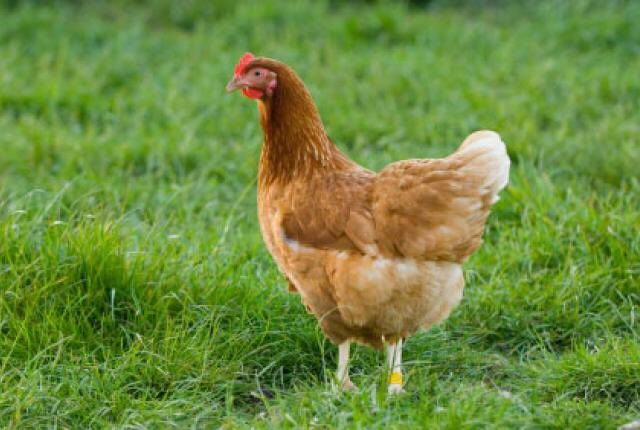

In [22]:
Disp.Image(requests.get('https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg', verify=False).content)

So there are images where no dog is present!

C:\Apps\Continuum\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pbs.twimg.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


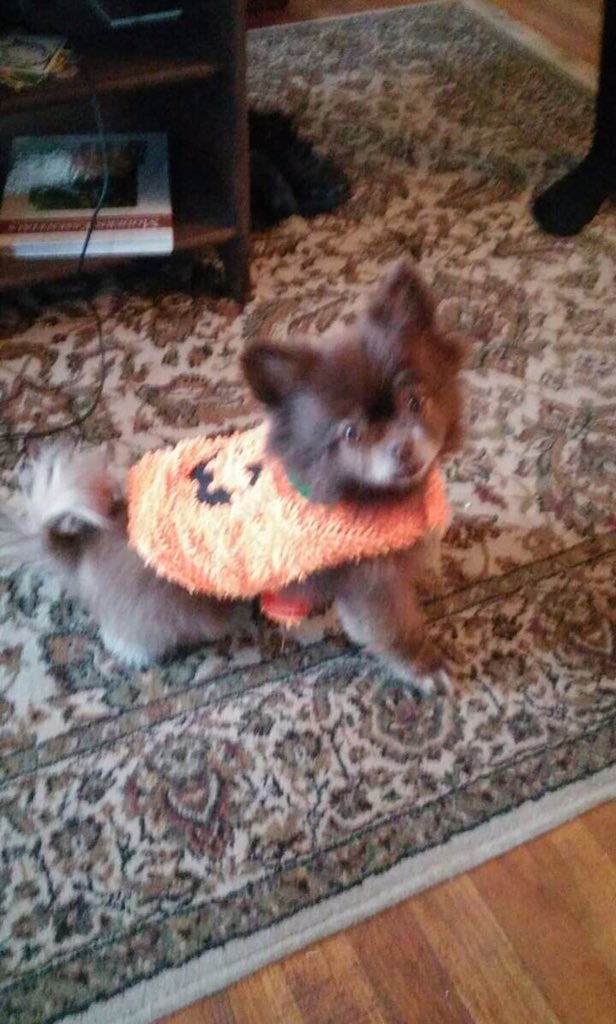

In [23]:
Disp.Image(requests.get(d, verify=False).content)

But the image recognition program struggles where the dog is blurred.

C:\Apps\Continuum\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pbs.twimg.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


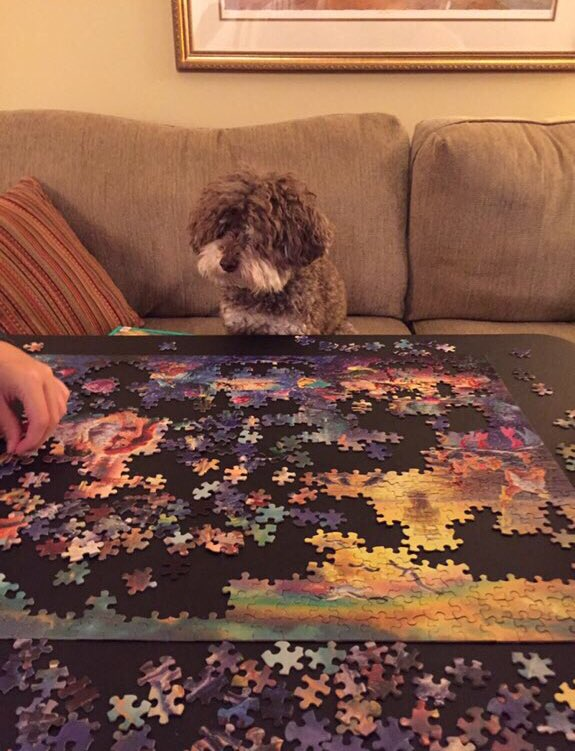

In [24]:
Disp.Image(requests.get(e, verify=False).content)

Or where the dog has a similar colour to the background of the image.

**Quality Issue #8**: Whilst dogs are present in images where no dog was identified by the image classifier, it will be quickest to simply remove all images where no dog was identified

**Tidiness Issue #3**: Only the first recognised dog per image is of use and therefore all other data could be removed. The images selected can be merged with the WeRateDogs Twitter archive. 

Do all the tweeted images correspond to a tweet in the WeRateDogs Twitter Archive?

In [25]:
twit['tweet_id'].isin(imgclass['tweet_id']).value_counts()

True     2075
False    281 
Name: tweet_id, dtype: int64

**Quality Issue #9**: There are 281 tweet_id values which are unique in either the WeRateDogs Twitter Archive and the image classification database suggesting some tweets do not have images.

#### WeRateDogs Twitter JSON data

In [26]:
twit_inf

tweet_id  retweet_count  favorite_count
0     892420643555336193  8853           39467         
1     892177421306343426  6514           33819         
2     891815181378084864  4328           25461         
3     891689557279858688  8964           42908         
4     891327558926688256  9774           41048         
...                  ...   ...             ...         
2349  666049248165822465  41             111           
2350  666044226329800704  147            311           
2351  666033412701032449  47             128           
2352  666029285002620928  48             132           
2353  666020888022790149  532            2535          

[2354 rows x 3 columns]

In [27]:
twit_inf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


The WeRateDogs Twitter JSON data contains 2354 entries and 3 variables.

There appears to be no missing data according to the Non-Null Count.

WeRateDogs Twitter JSON data column descriptions:
- **tweet_id**: Unique numerical identifier for each Tweet
- **retweet_count**: Count of the number of times the Tweet has been retweeted
- **favorite_count**: Count of the number of times the Tweet has been "liked"

There appears to be a different number of entries compared to the WeRateDogs Twitter archive, is this a problem?

In [28]:
twit_inf.describe()

tweet_id  retweet_count  favorite_count
count  2.354000e+03  2354.000000    2354.000000   
mean   7.426978e+17  3164.797366    8080.968564   
std    6.852812e+16  5284.770364    11814.771334  
min    6.660209e+17  0.000000       0.000000      
25%    6.783975e+17  624.500000     1415.000000   
50%    7.194596e+17  1473.500000    3603.500000   
75%    7.993058e+17  3652.000000    10122.250000  
max    8.924206e+17  79515.000000   132810.000000

In [29]:
twit['tweet_id'].isin(twit_inf['tweet_id']).value_counts()

True     2354
False    2   
Name: tweet_id, dtype: int64

**Quality Issue #10**: There are two tweet_id entries which are not present in the WeRateDogs Twitter archive which will have to be removed.

**Tidiness Issue #4**: The retweet_count and favorite_count should be merged with the WeRateDogs Twitter archive to make a single queryable database.

<a id='clean'></a>
### Cleaning Data

The data's quality and tidiness issues will be resolved taking each database at a time.

#### WeRateDogs Twitter archive

In [30]:
# Create a copy of WeRateDogs Twitter archive to clean
twit_clean = twit.copy()

##### Quality Issue # 4 - Define

Remove all retweet data as it is duplicated data within archive.

##### Quality Issue # 4 - Code

In [31]:
twit_clean = twit_clean[pd.isnull(twit_clean['retweeted_status_id'])]

##### Quality Issue # 4 - Test

In [32]:
twit_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

##### Tidiness Issue # 5 - Define

Remove all retweet data columns as they are redundant.

##### Tidiness Issue # 5 - Code

In [33]:
twit_clean.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'], axis=1, inplace=True)

##### Tidiness Issue # 5 - Test

In [34]:
twit_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2175 non-null   int64  
 1   in_reply_to_status_id  78 non-null     float64
 2   in_reply_to_user_id    78 non-null     float64
 3   timestamp              2175 non-null   object 
 4   source                 2175 non-null   object 
 5   text                   2175 non-null   object 
 6   expanded_urls          2117 non-null   object 
 7   rating_numerator       2175 non-null   int64  
 8   rating_denominator     2175 non-null   int64  
 9   name                   2175 non-null   object 
 10  doggo                  2175 non-null   object 
 11  floofer                2175 non-null   object 
 12  pupper                 2175 non-null   object 
 13  puppo                  2175 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 254.9+ 

##### Quality Issue # 1,2,3 - Define

Resolve incorrect data types for in_reply_to_status_id and in_reply_to_user_id which should be integers and timestamp which should be datetime.

##### Quality Issue # 1,2,3 - Code

In [35]:
# Change in_reply_to_status_id and in_reply_to_user_id data type
cols = ['in_reply_to_status_id', 'in_reply_to_user_id']
twit_clean[cols] = twit_clean[cols].fillna(0.0).applymap(np.int64)

# Change timestamp data type
twit_clean['timestamp'] = pd.to_datetime(twit_clean['timestamp'])

##### Quality Issue # 1,2,3 - Test

In [36]:
twit_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2175 non-null   int64              
 1   in_reply_to_status_id  2175 non-null   int64              
 2   in_reply_to_user_id    2175 non-null   int64              
 3   timestamp              2175 non-null   datetime64[ns, UTC]
 4   source                 2175 non-null   object             
 5   text                   2175 non-null   object             
 6   expanded_urls          2117 non-null   object             
 7   rating_numerator       2175 non-null   int64              
 8   rating_denominator     2175 non-null   int64              
 9   name                   2175 non-null   object             
 10  doggo                  2175 non-null   object             
 11  floofer                2175 non-null   object           

##### Quality Issue # 6 - Define

Not all dog names correctly identified. Attempt to replace all lowercase words in the name column with the correct name. 

##### Quality Issue # 6 - Code

In [37]:
# Create dataframe of only 'name' and 'text' to enable easier evaluation
twit_clean_nm = pd.DataFrame()
twit_clean_nm = twit_clean[['name', 'text']]
twit_clean_nm = twit_clean_nm.loc[(twit_clean_nm['name'].str.islower())]

# As identified in the assess phase, Tweets containing "We only rate dogs" or "It is not a dog" do not have names
twit_clean_nm.loc[twit_clean_nm.text.str.contains("We only rate dogs"), 'name'] = "Unknown"
twit_clean_nm.loc[twit_clean_nm.text.str.contains("It is not a dog"), 'name'] = "Unknown"

# Copy name after "name is" or "named"
twit_clean_nm['Name1'] = twit_clean_nm['text'].str.extract(r"(?<=\bnamed\b)(\s+\w*\s*\w*\s*\w*)")
twit_clean_nm['Name2'] = twit_clean_nm['text'].str.extract(r"(?<=\bname is\b)(\s+\w*\s*\w*\s*\w*)")
twit_clean_nm['name'].update(twit_clean_nm.pop('Name1'))
twit_clean_nm['name'].update(twit_clean_nm.pop('Name2'))
twit_clean_nm.name = twit_clean_nm.name.str.replace(' ', '')

# Replace all other lower-case values with "None"
twit_clean_nm.loc[twit_clean_nm.name.str.contains('^[a-z]+'), 'name'] = "Unknown"

# Update twit_clean dataframe with new data
twit_clean.update(twit_clean_nm)
twit_clean.name = twit_clean.name.str.replace('None', 'Unknown')

##### Quality Issue # 6 - Test

In [38]:
twit_clean.name.value_counts()

Unknown    762
Charlie    11 
Lucy       11 
Cooper     10 
Oliver     10 
           .. 
Berb       1  
Murphy     1  
Fynn       1  
Julius     1  
Glacier    1  
Name: name, Length: 949, dtype: int64

##### Quality Issue # 5 - Define

Dog ratings have decimal numbers but in the WeRateDogs archive they are whole integers

##### Quality Issue # 5 - Code

In [39]:
# Find Tweets with decimals as numerators
twit_clean[twit_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

C:\Apps\Continuum\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
45    883482846933004288  0                      0                     
695   786709082849828864  0                      0                     
763   778027034220126208  0                      0                     
1689  681340665377193984  681339448655802368     4196983835            
1712  680494726643068929  0                      0                     

                     timestamp  \
45   2017-07-08 00:28:19+00:00   
695  2016-10-13 23:23:56+00:00   
763  2016-09-20 00:24:34+00:00   
1689 2015-12-28 05:07:27+00:00   
1712 2015-12-25 21:06:00+00:00   

                                                                                  source  \
45    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
695   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
763   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1689  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1712  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                                                   text  \
45    This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948                            
695   This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS                                    
763   This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq   
1689  I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace                                                          
1712  Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD                                                          

                                                                                                                        expanded_urls  \
45    https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1   
695   https://twitter.com/dog_rates/status/786709082849828864/photo/1                                                                   
763   https://twitter.com/dog_rates/status/778027034220126208/photo/1                                                                   
1689  NaN                                                                                                                               
1712  https://twitter.com/dog_rates/status/680494726643068929/photo/1                                                                   

      rating_numerator  rating_denominator     name doggo floofer  pupper  \
45    5                 10                  Bella    None  None    None     
695   75                10                  Logan    None  None    None     
763   27                10                  Sophie   None  None    pupper   
1689  5                 10                  Unknown  None  None    None     
1712  26                10                  Unknown  None  None    None     

     puppo  
45    None  
695   None  
763   None  
1689  None  
1712  None

In [40]:
# Convert data type of numerator and denominator columns to float
cols = ['rating_numerator', 'rating_denominator']
twit_clean[cols] = twit_clean[cols].fillna(0.0).applymap(np.float64)

# Change numerator for Tweets affected
twit_clean.loc[(twit_clean['tweet_id'] == 883482846933004288), ['rating_numerator']] = 13.5
twit_clean.loc[(twit_clean['tweet_id'] == 786709082849828864), ['rating_numerator']] = 9.75
twit_clean.loc[(twit_clean['tweet_id'] == 778027034220126208), ['rating_numerator']] = 11.27
twit_clean.loc[(twit_clean['tweet_id'] == 681340665377193984), ['rating_numerator']] = 9.5
twit_clean.loc[(twit_clean['tweet_id'] == 680494726643068929), ['rating_numerator']] = 11.26

##### Quality Issue # 5 - Test

In [41]:
twit_clean[twit_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

C:\Apps\Continuum\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
45    883482846933004288  0                      0                     
695   786709082849828864  0                      0                     
763   778027034220126208  0                      0                     
1689  681340665377193984  681339448655802368     4196983835            
1712  680494726643068929  0                      0                     

                     timestamp  \
45   2017-07-08 00:28:19+00:00   
695  2016-10-13 23:23:56+00:00   
763  2016-09-20 00:24:34+00:00   
1689 2015-12-28 05:07:27+00:00   
1712 2015-12-25 21:06:00+00:00   

                                                                                  source  \
45    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
695   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
763   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1689  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1712  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                                                   text  \
45    This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948                            
695   This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS                                    
763   This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq   
1689  I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace                                                          
1712  Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD                                                          

                                                                                                                        expanded_urls  \
45    https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1   
695   https://twitter.com/dog_rates/status/786709082849828864/photo/1                                                                   
763   https://twitter.com/dog_rates/status/778027034220126208/photo/1                                                                   
1689  NaN                                                                                                                               
1712  https://twitter.com/dog_rates/status/680494726643068929/photo/1                                                                   

      rating_numerator  rating_denominator     name doggo floofer  pupper  \
45    13.50             10.0                Bella    None  None    None     
695   9.75              10.0                Logan    None  None    None     
763   11.27             10.0                Sophie   None  None    pupper   
1689  9.50              10.0                Unknown  None  None    None     
1712  11.26             10.0                Unknown  None  None    None     

     puppo  
45    None  
695   None  
763   None  
1689  None  
1712  None

##### Quality Issue # 6 & Tidiness Issue #1 - Define

Dog "stage" can be combined into one column and simplified

##### Quality Issue # 6 & Tidiness Issue #1 - Code

In [42]:
# Combine columns preserving values
twit_cleana = twit_clean[['doggo','floofer','pupper','puppo']].replace('None', np.nan)
twit_cleana['stage'] = twit_cleana.apply(lambda x: '-'.join(x.dropna().astype(str).values), axis=1)
twit_cleana['stage'] = twit_cleana['stage'].replace('', 'Unknown')

# Combine with original clean dataframe and remove unnecessary columns
twit_clean['stage'] = twit_cleana['stage']
twit_clean.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace=True)

##### Quality Issue # 6 & Tidiness Issue #1 - Test

In [43]:
twit_clean.stage.value_counts()

Unknown          1831
pupper           224 
doggo            75  
puppo            24  
doggo-pupper     10  
floofer          9   
doggo-floofer    1   
doggo-puppo      1   
Name: stage, dtype: int64

##### Tidiness Issue #2 - Define

The 'source' or method used to post the Tweet is unnecessarily long including URLs. This can be shortened.

##### Tidiness Issue #2 - Code

In [44]:
twit_clean['source'] = twit_clean.source.apply(lambda st: st[st.find(">")+1:st.find("</")])

##### Tidiness Issue #2 - Test

In [45]:
twit_clean.source.value_counts()

Twitter for iPhone     2042
Vine - Make a Scene    91  
Twitter Web Client     31  
TweetDeck              11  
Name: source, dtype: int64

#### Tweet image classification

In [46]:
# Create a copy of Tweet image classification to clean
imgclass_clean = imgclass.copy()

##### Quality Issue #8 & Tidiness Issue #3 - Define

There are a number of images where no dog was classified or where multiple breed were identified all of which is extraneous data. The below will remove all data where no dog was recognised in a Tweet or only keep the first breed of dog recognised.

##### Quality Issue #8 & Tidiness Issue #3 - Code

In [47]:
# Create empty dataframe
columns = ['tweet_id','breed']
imgclassone = pd.DataFrame(columns=columns)

# Fill dataframe with first True dog identified
for i in imgclass_clean.index:
    imgclassone['tweet_id'] = imgclass_clean['tweet_id']
    if imgclass_clean.p1_dog.loc[i] == True:
        imgclassone.breed.loc[i] = imgclass_clean.p1.loc[i]
    elif imgclass_clean.p2_dog.loc[i] == True:
        imgclassone.breed.loc[i] = imgclass_clean.p2.loc[i]
    elif imgclass_clean.p3_dog.loc[i] == True:
        imgclassone.breed.loc[i] = imgclass_clean.p3.loc[i]
    else:
        imgclassone.breed.loc[i] = "Unknown"
        
# Make breed names nice
imgclassone['breed'] = imgclassone['breed'].replace('_', ' ', regex=True).str.title()

C:\Apps\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


##### Quality Issue #8 & Tidiness Issue #3 - Test

In [48]:
imgclassone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  2075 non-null   int64 
 1   breed     2075 non-null   object
dtypes: int64(1), object(1)
memory usage: 32.5+ KB


In [49]:
imgclassone.breed.value_counts()

Unknown                           324
Golden Retriever                  173
Labrador Retriever                113
Pembroke                          96 
Chihuahua                         95 
Pug                               65 
Toy Poodle                        52 
Chow                              51 
Samoyed                           46 
Pomeranian                        42 
Malamute                          34 
Cocker Spaniel                    34 
French Bulldog                    32 
Chesapeake Bay Retriever          31 
Miniature Pinscher                26 
Cardigan                          23 
Eskimo Dog                        22 
Staffordshire Bullterrier         22 
Beagle                            21 
German Shepherd                   21 
Siberian Husky                    20 
Shih-Tzu                          20 
Maltese Dog                       19 
Kuvasz                            19 
Rottweiler                        19 
Lakeland Terrier                  19 
Shetland She

##### Quality Issue #9 & 10 & Tidiness Issue #4 - Define

Both the JSON data composed of favourites and retweeted tweet statistics and the image classification data pertain to the WeRateDogs Twitter Archive and are ready to be merged to create one database.

##### Quality Issue #9 & 10 & Tidiness Issue #4 - Code

In [50]:
# Merge image classification data with WeRateDgos Twitter Archive
weratedogsall = twit_clean.merge(imgclassone, left_on='tweet_id', right_on='tweet_id')

# Merge Tweet favourite and retweet count data with WeRateDgos Twitter Archive
weratedogsall = weratedogsall.merge(twit_inf, left_on='tweet_id', right_on='tweet_id')

##### Quality Issue #9 & 10 & Tidiness Issue #4 - Test

In [51]:
weratedogsall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               1994 non-null   int64              
 1   in_reply_to_status_id  1994 non-null   int64              
 2   in_reply_to_user_id    1994 non-null   int64              
 3   timestamp              1994 non-null   datetime64[ns, UTC]
 4   source                 1994 non-null   object             
 5   text                   1994 non-null   object             
 6   expanded_urls          1994 non-null   object             
 7   rating_numerator       1994 non-null   float64            
 8   rating_denominator     1994 non-null   float64            
 9   name                   1994 non-null   object             
 10  stage                  1994 non-null   object             
 11  breed                  1994 non-null   object           

In [52]:
# And to ensure it is correct, the below samples two random tweet_ids to compare the merge to original data
weratedogsall[(weratedogsall['tweet_id'] == 688211956440801280) | (weratedogsall['tweet_id'] == 670822709593571328)]

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1241  688211956440801280  0                      0                     
1725  670822709593571328  0                      0                     

                     timestamp              source  \
1241 2016-01-16 04:11:31+00:00  Twitter for iPhone   
1725 2015-11-29 04:32:51+00:00  Twitter for iPhone   

                                                                                    text  \
1241  This is Derby. He's a superstar. 13/10 (vid by @NBohlmann) https://t.co/o4Nfc8WoAO   
1725  Can't do better than this lol. 10/10 for the owner https://t.co/yrqGyMZhW6           

                                                        expanded_urls  \
1241  https://twitter.com/dog_rates/status/688211956440801280/video/1   
1725  https://twitter.com/dog_rates/status/670822709593571328/photo/1   

      rating_numerator  rating_denominator     name    stage      breed  \
1241  13.0              10.0                Derby    Unknown  Unknown     
1725  10.0              10.0                Unknown  Unknown  Chihuahua   

      retweet_count  favorite_count  
1241  937            2426            
1725  105            647

In [53]:
# With clean WeRateDogs Twitter Archive
twit_clean[(twit_clean['tweet_id'] == 688211956440801280) | (twit_clean['tweet_id'] == 670822709593571328)]

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1562  688211956440801280  0                      0                     
2081  670822709593571328  0                      0                     

                     timestamp              source  \
1562 2016-01-16 04:11:31+00:00  Twitter for iPhone   
2081 2015-11-29 04:32:51+00:00  Twitter for iPhone   

                                                                                    text  \
1562  This is Derby. He's a superstar. 13/10 (vid by @NBohlmann) https://t.co/o4Nfc8WoAO   
2081  Can't do better than this lol. 10/10 for the owner https://t.co/yrqGyMZhW6           

                                                        expanded_urls  \
1562  https://twitter.com/dog_rates/status/688211956440801280/video/1   
2081  https://twitter.com/dog_rates/status/670822709593571328/photo/1   

      rating_numerator  rating_denominator     name    stage  
1562  13.0              10.0                Derby    Unknown  
2081  10.0              10.0                Unknown  Unknown

In [54]:
# With clean image classification database
imgclassone[(imgclassone['tweet_id'] == 688211956440801280) | (imgclassone['tweet_id'] == 670822709593571328)]

tweet_id      breed
270  670822709593571328  Chihuahua
754  688211956440801280  Unknown

In [55]:
# With JSON database
twit_inf[(twit_inf['tweet_id'] == 688211956440801280) | (twit_inf['tweet_id'] == 670822709593571328)]

tweet_id  retweet_count  favorite_count
1560  688211956440801280  937            2426          
2079  670822709593571328  105            647

<a id='store'></a>
### Storing Data

In [56]:
weratedogsall.to_csv("twitter_archive_master.csv", encoding='utf-8', index=False)

<a id='anal'></a>
### Analysing Data

In [57]:
# For simple charting, the below function renames axis and titles which will be called regularly
def pltlab(title,x_label,y_label):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
matplotlib.rcParams.update({'font.size': 14})

#### Univariate Exploration

##### What is the trend of Tweeting on the WeRateDogs (@dog_rates) Twitter feed?

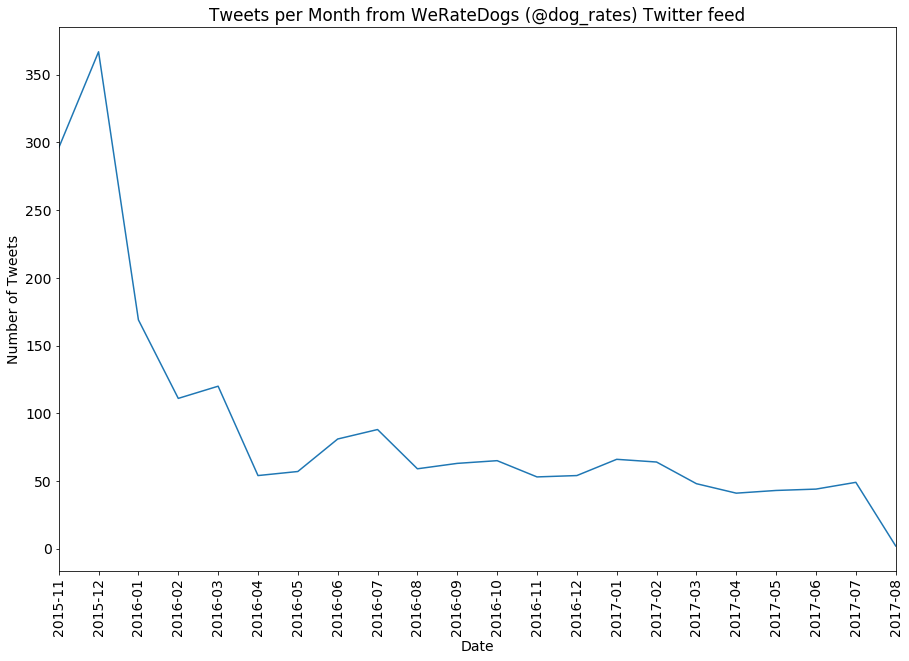

In [58]:
# Sort data
weratedogsall['timestamp'] = pd.to_datetime(weratedogsall['timestamp'])
m = weratedogsall.tweet_id.groupby([weratedogsall['timestamp'].dt.strftime('%Y-%m')]).count().to_frame()

# Plot data
plt.figure(figsize=(15,10))
sb.lineplot(x=m.index, y=m.tweet_id)
plt.xticks(rotation=90)
plt.xlim(['2015-11', '2017-08'])
pltlab('Tweets per Month from WeRateDogs (@dog_rates) Twitter feed','Date','Number of Tweets')

There has been a general decline in Tweet activity on the WeRateDogs (@dog_rates) Twitter feed from 11/2015 to 08/2017.

##### What is the breakdown of source for Tweets on WeRateDogs (@dog_rates)?

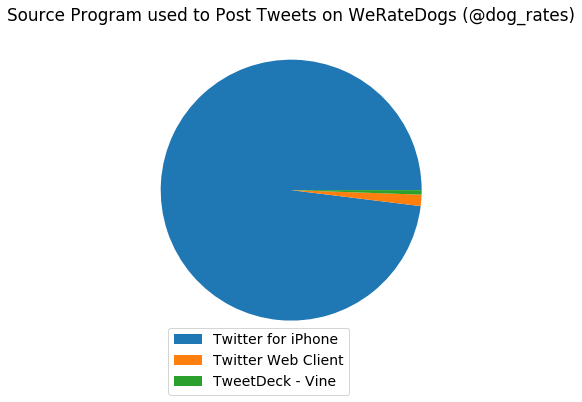

In [59]:
labels = ['Twitter for iPhone','Twitter Web Client','TweetDeck - Vine']
plt.figure(figsize=(6, 6), dpi=72)
weratedogsall.source.value_counts().plot.pie(labels=labels, labeldistance=None)
plt.title('Source Program used to Post Tweets on WeRateDogs (@dog_rates)')
plt.legend(labels=labels, loc = 'upper right')
plt.axis('off')
plt.legend(bbox_to_anchor=(0.7, 0.1))
plt.show()

By far the most popular client for posting on @dog_rates is Twitter for iPhone.

##### What are the twenty most popular dog names on WeRateDogs (@dog_rates)?

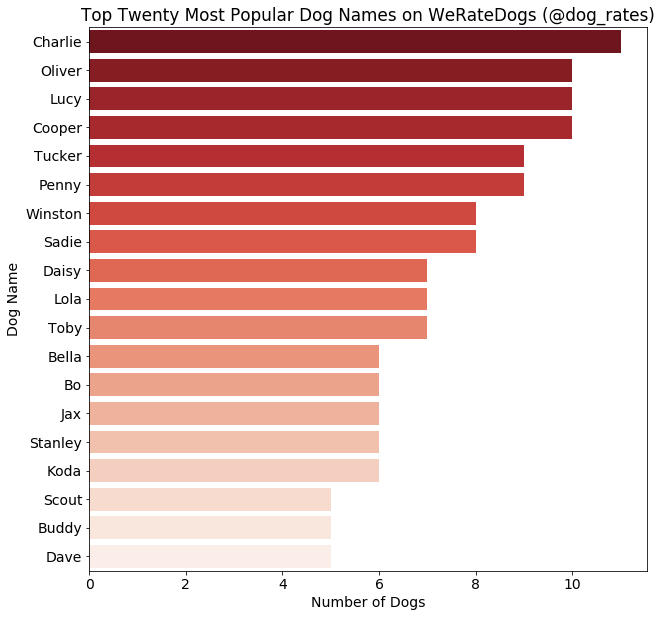

In [60]:
plt.figure(figsize=(10,10))
sb.countplot(palette = "Reds_r", data=weratedogsall, y='name', order=weratedogsall.name.value_counts().iloc[1:20].index)
pltlab('Top Twenty Most Popular Dog Names on WeRateDogs (@dog_rates)','Number of Dogs','Dog Name')

Charlie is the most popular dog name posted on @dog_rates.

##### What are the "stages" of dogs posted on WeRateDogs (@dog_rates)?

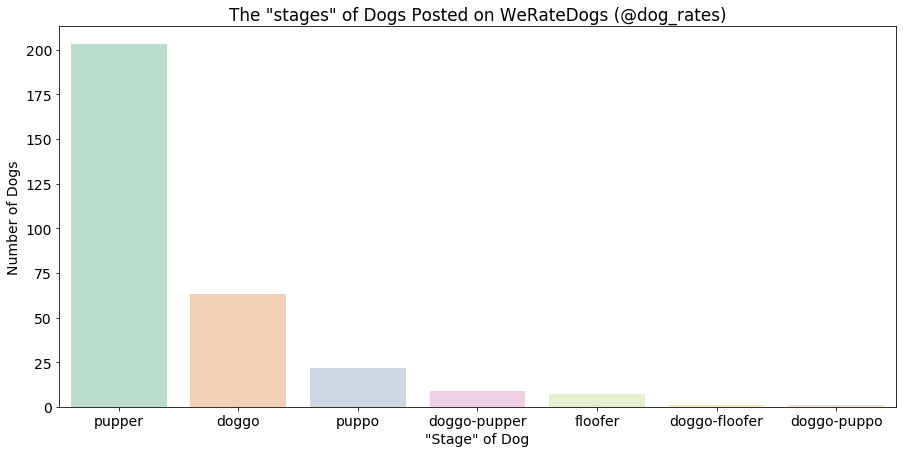

In [61]:
plt.figure(figsize=(15,7))
sb.countplot(palette = "Pastel2", data=weratedogsall, x='stage', order=weratedogsall.stage.value_counts().iloc[1:].index)
pltlab('The "stages" of Dogs Posted on WeRateDogs (@dog_rates)','"Stage" of Dog','Number of Dogs')

A pupper, a young dog like a puppy, is the most commonly identified "stage" of dogs posted on @dog_rates. 

##### What are the breeds of dogs posted on WeRateDogs (@dog_rates)?

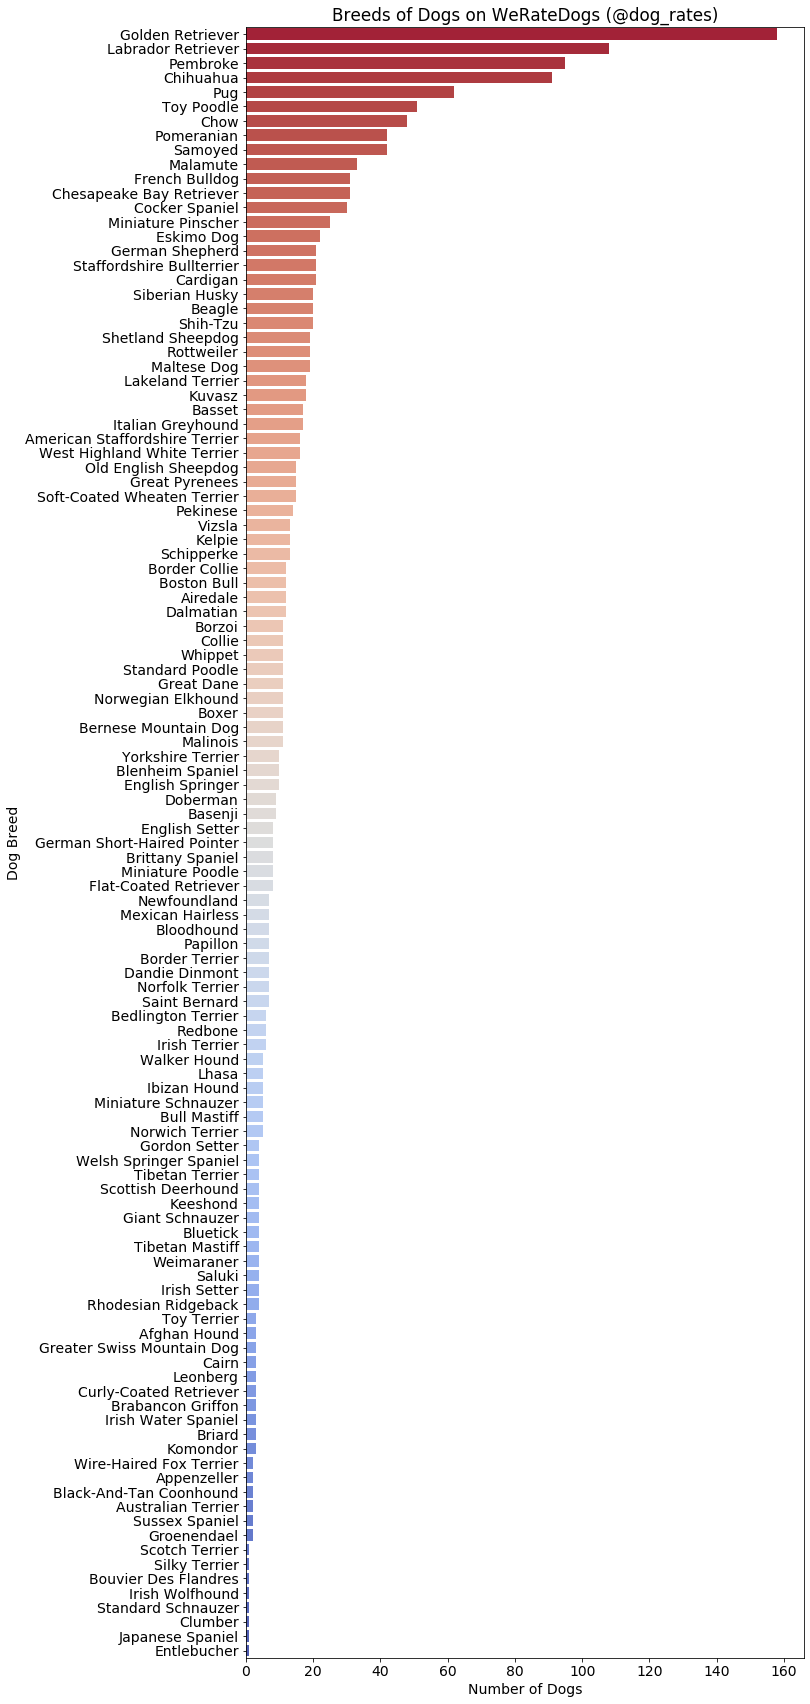

In [62]:
# Format types of breeds to remove symbols and ensure capital letters are used for plotting
b = weratedogsall["breed"].value_counts().iloc[1:].reset_index()

# Plot data
plt.figure(figsize=(10,30))
sb.barplot(x="breed", y="index", data=b, palette = "coolwarm_r")
pltlab('Breeds of Dogs on WeRateDogs (@dog_rates)','Number of Dogs','Dog Breed')

Golden Retriever breed, followed by Labrador Retriever, is the most common breed posted on @dog_rates.

#### Bivariate Exploration

##### What is the trend of Re-Tweeting and Favouriting on the WeRateDogs (@dog_rates) Twitter feed?

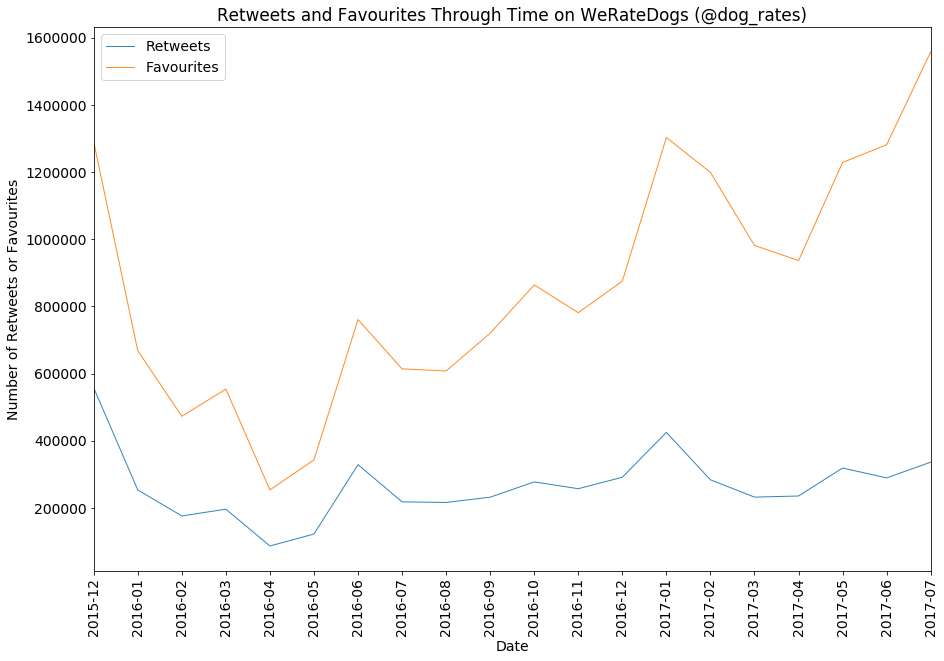

In [63]:
# Sort data
n = weratedogsall.retweet_count.groupby([weratedogsall['timestamp'].dt.strftime('%Y-%m')]).sum().to_frame()
o = weratedogsall.favorite_count.groupby([weratedogsall['timestamp'].dt.strftime('%Y-%m')]).sum().to_frame()
p = n.merge(o, left_on='timestamp', right_on='timestamp')
p = p.reset_index()
p = p.iloc[1:-1]

# Plot data
plt.figure(figsize=(15,10))
num=0
for column in p.drop('timestamp', axis=1):
    num+=1
    plt.plot(p['timestamp'], p[column], marker='', linewidth=1, alpha=0.9, label=column)
plt.legend(('Retweets', 'Favourites'))
plt.xticks(rotation=90)
plt.xlim(['2015-12', '2017-07'])
pltlab('Retweets and Favourites Through Time on WeRateDogs (@dog_rates)','Date','Number of Retweets or Favourites')

Retweets and Favourits have been increasing in number through time.

##### Which breeds of dogs gain the most retweets on WeRateDogs (@dog_rates)?

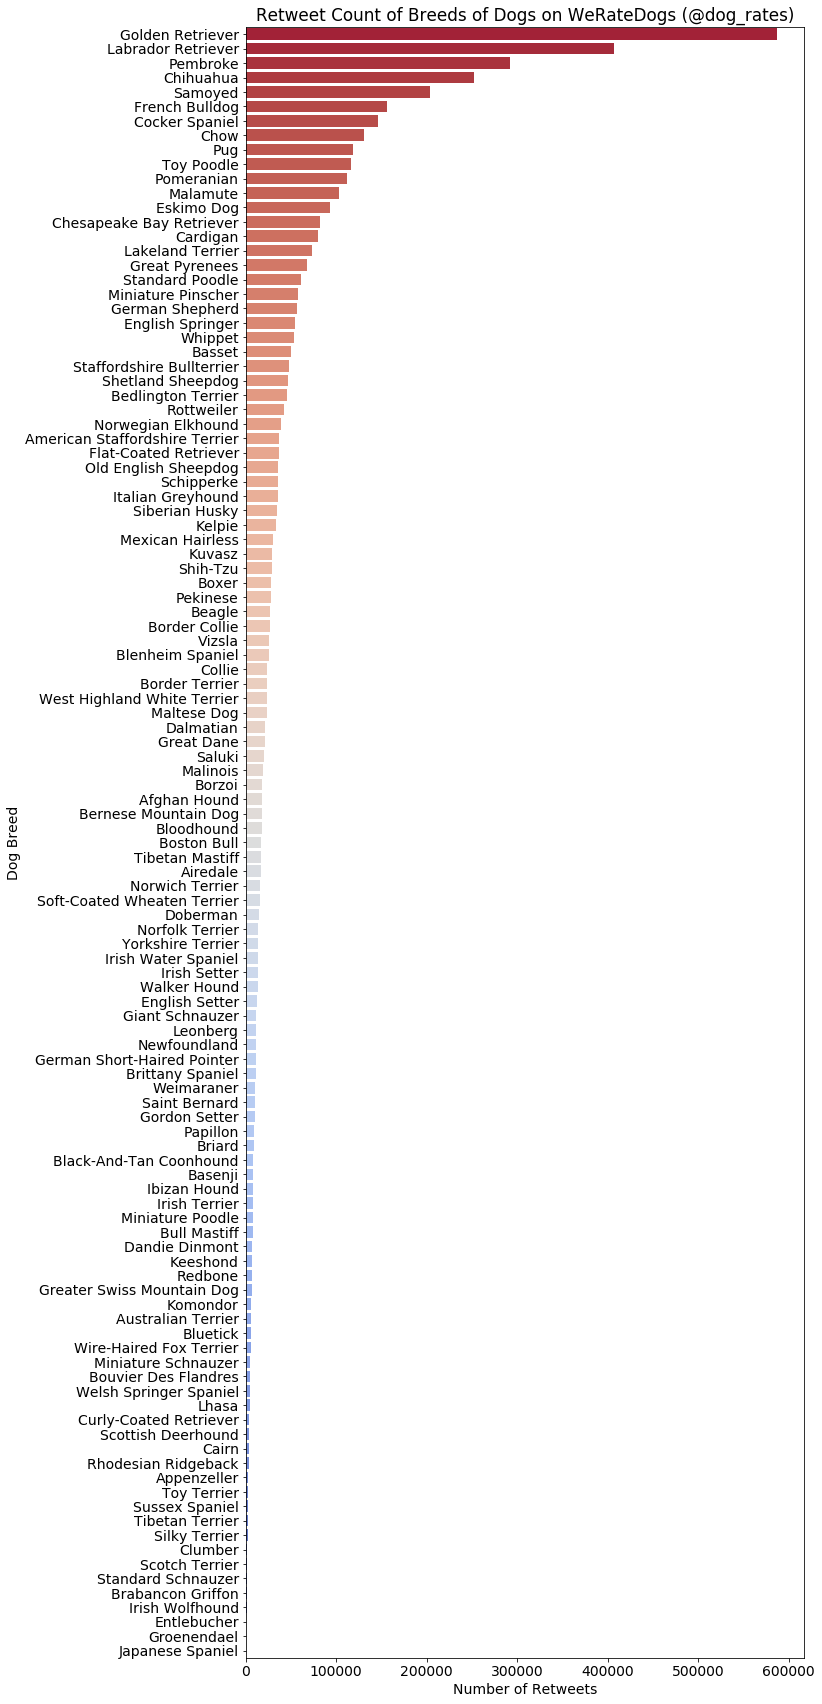

In [64]:
# Format data
c = weratedogsall[['breed', 'retweet_count']]
cc = c.groupby(['breed'])['retweet_count'].agg('sum').reset_index()
cc = cc.sort_values(by='retweet_count', ascending=False).iloc[1:].reset_index()

# Plot data
plt.figure(figsize=(10,30))
sb.barplot(x="retweet_count", y="breed", data=cc, palette = "coolwarm_r")
pltlab('Retweet Count of Breeds of Dogs on WeRateDogs (@dog_rates)','Number of Retweets','Dog Breed')

The order of most retweets is similar to the order of number of tweets by breed suggesting more Tweets of a certain breed of dog is likely to lead to more retweets. However, if the data is re-analysed to reveal the number of retweets per breed the story may be different.

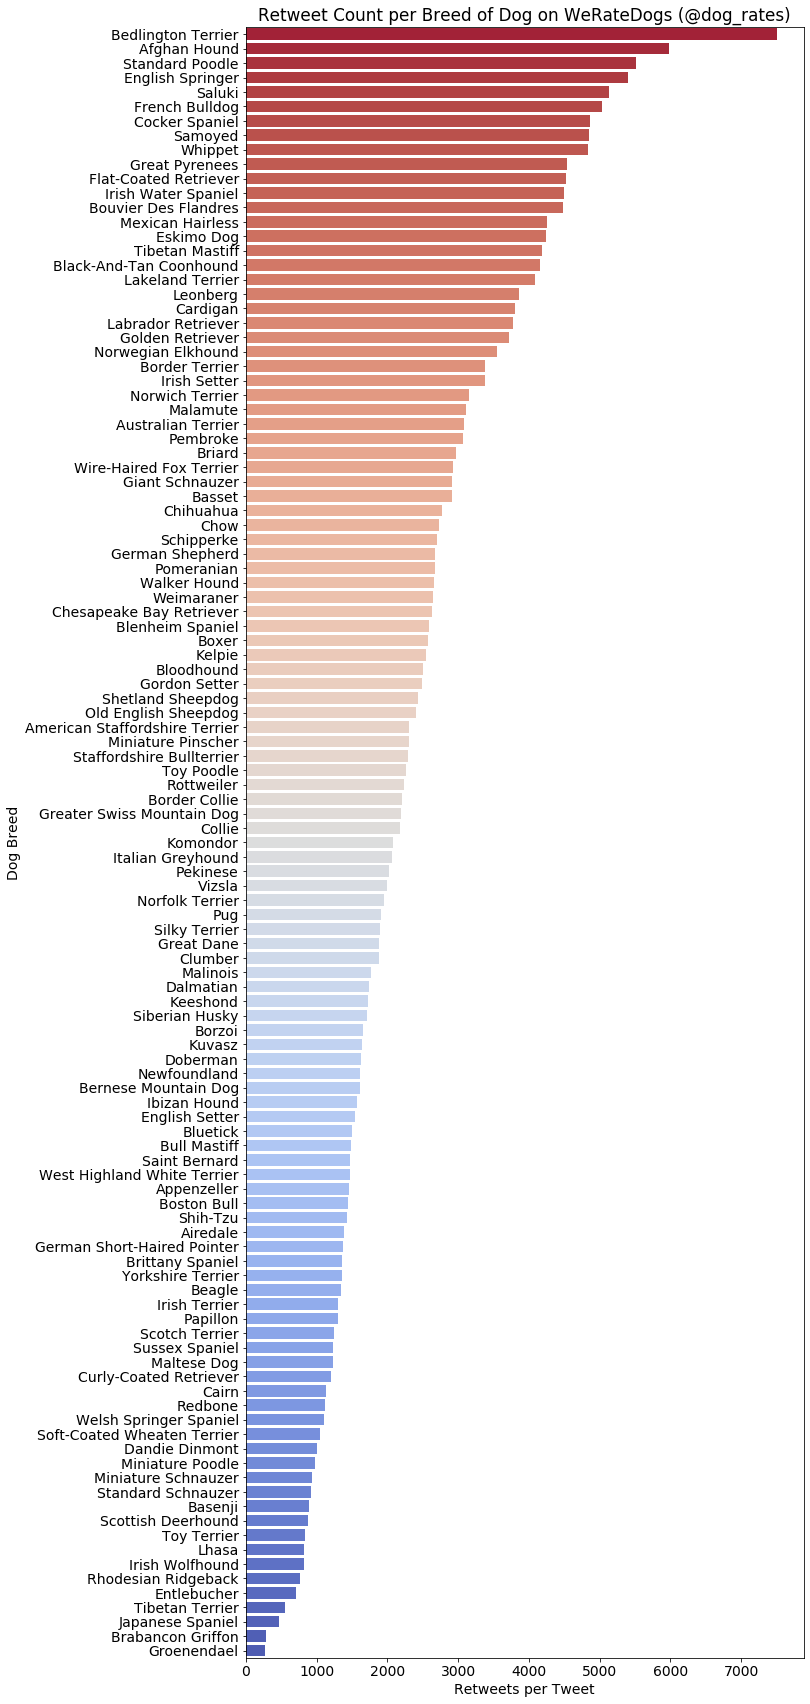

In [65]:
# Sort data
d = b.merge(cc, left_on='index', right_on='breed')
d['retweet_per_breed'] = d['retweet_count']/d['breed_x']
d.drop(['index_y','breed_y'], axis=1, inplace=True)
d = d.sort_values(by='retweet_per_breed', ascending=False).reset_index()

# Plot data
plt.figure(figsize=(10,30))
sb.barplot(x="retweet_per_breed", y="index_x", data=d, palette = "coolwarm_r")
pltlab('Retweet Count per Breed of Dog on WeRateDogs (@dog_rates)','Retweets per Tweet','Dog Breed')

Here we can see that it is actually the Bedlington Terrier which gains the most retweets based on the number of tweets containing that breed. 

##### Which breeds of dogs gain the most favourites per tweet on WeRateDogs (@dog_rates)?

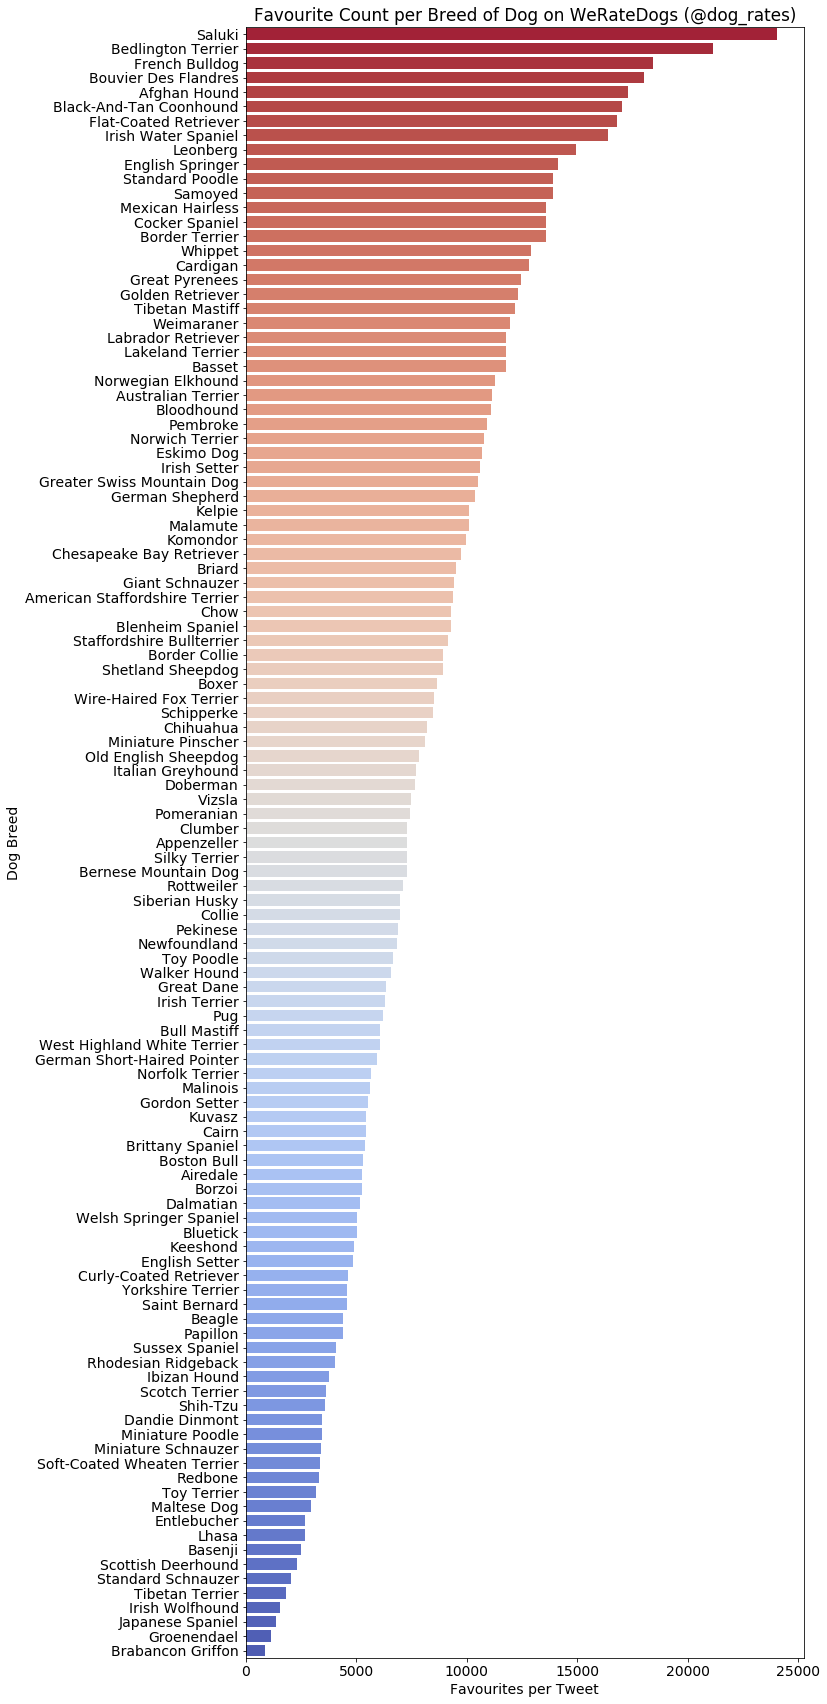

In [66]:
# Sort data
e = weratedogsall[['breed', 'favorite_count']]
e = e.groupby(['breed'])['favorite_count'].agg('sum').reset_index()
ee = e.merge(b, left_on='breed', right_on='index')
ee['fav_per_breed'] = ee['favorite_count']/ee['breed_y']
ee = ee.sort_values(by='fav_per_breed', ascending=False).reset_index()

# Plot data
plt.figure(figsize=(10,30))
sb.barplot(x="fav_per_breed", y="index", data=ee, palette = "coolwarm_r")
pltlab('Favourite Count per Breed of Dog on WeRateDogs (@dog_rates)','Favourites per Tweet','Dog Breed')

Whilst the Bedlington Terrier is the most retweeted, it is pipped to top spot on favourites by the Saluki breed which gains the most favourites based on the number of tweets containing that breed. 

#### Multivariate Exploration

##### Which breeds of dogs gain the most favourites and retweets per tweet on WeRateDogs (@dog_rates)?

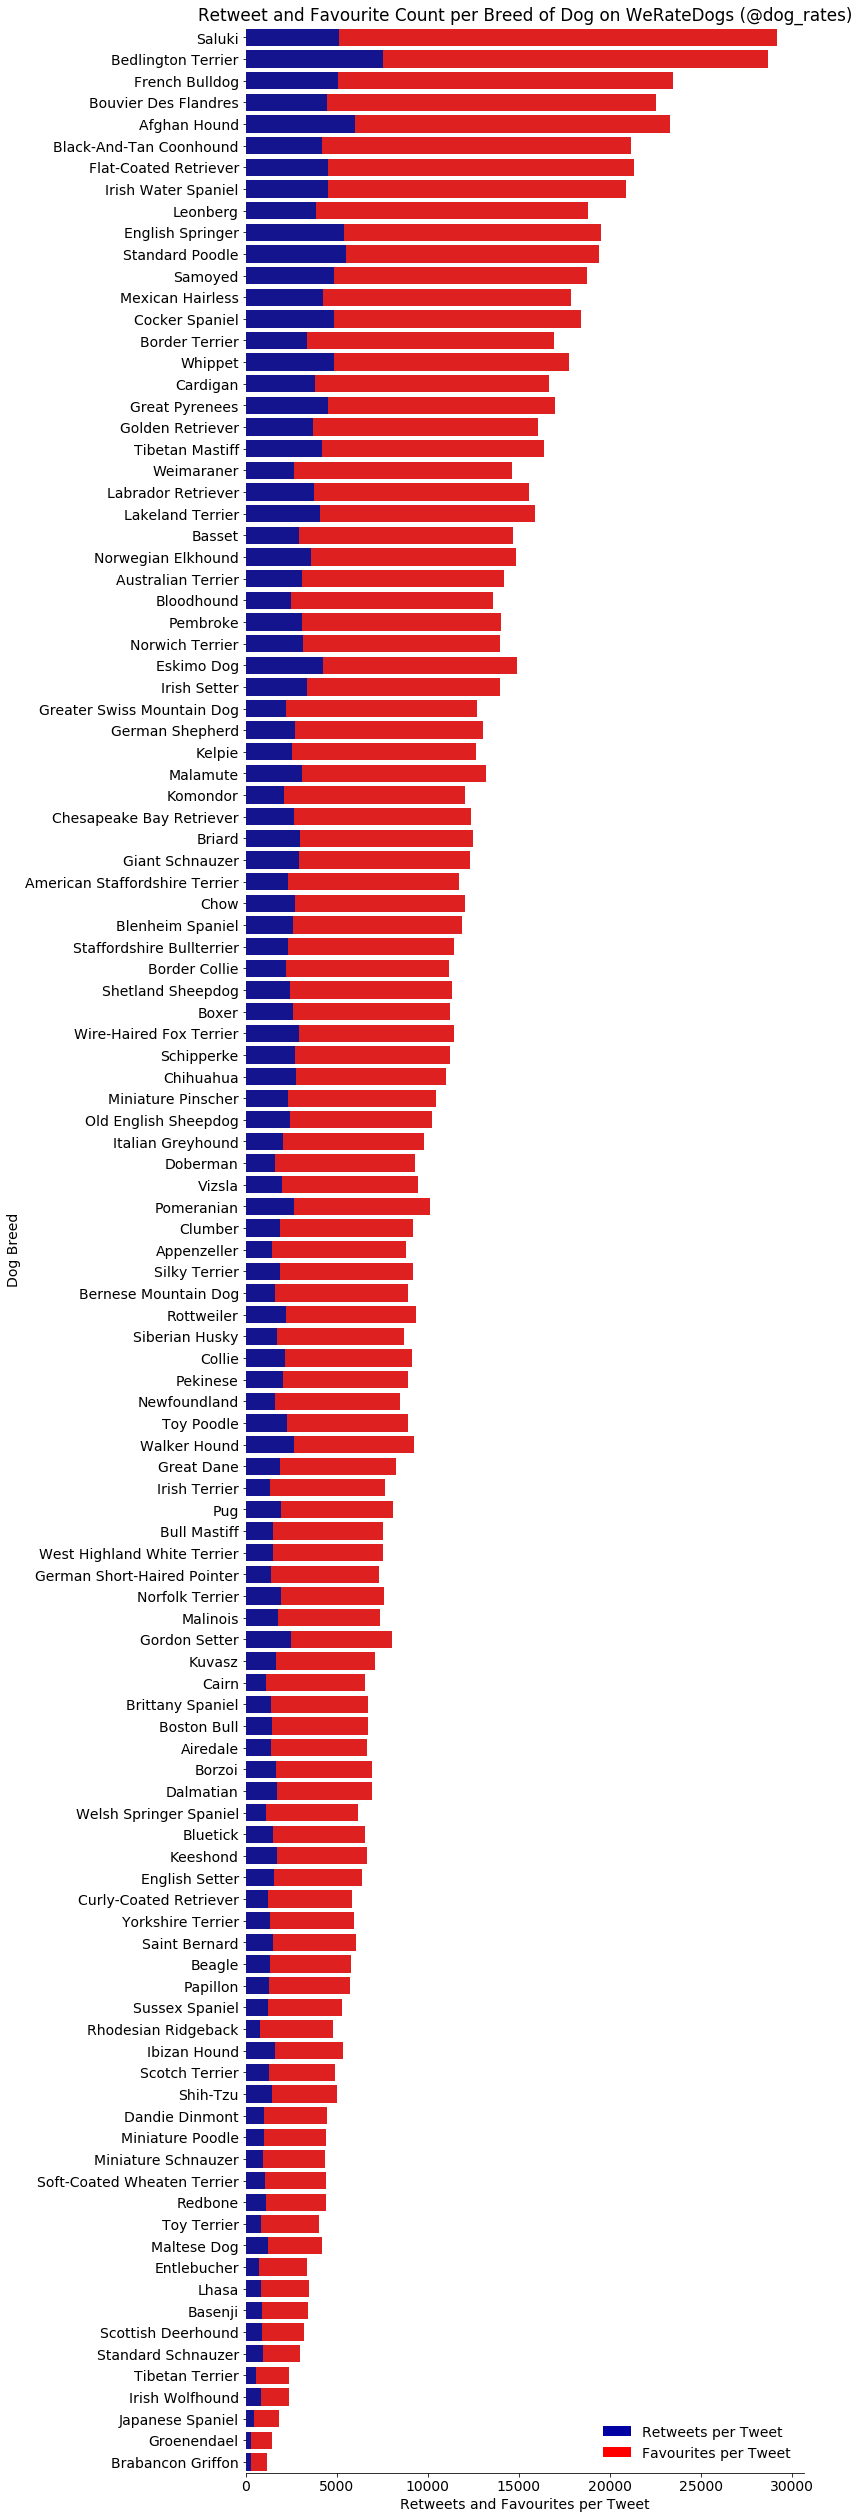

In [67]:
# Sort data
z = d.copy()
y = ee.copy()
y.drop(['favorite_count','level_0','breed_y','breed_x'], axis=1, inplace=True)
y.rename(columns = {'index':'breed'}, inplace = True)
z.drop(['index','breed_x','retweet_count'], axis=1, inplace=True)
z.rename(columns = {'index_x':'breed'}, inplace = True)
x = y.merge(z, left_on='breed', right_on='breed')
x['total'] = x.fav_per_breed + x.retweet_per_breed

# Plot data
plt.figure(figsize=(10,45))
sb.barplot(y = x.breed, x = x.total, color = "red")
bottom_plot = sb.barplot(y = x.breed, x = x.retweet_per_breed, color = "#0000A3")
topbar = plt.Rectangle((0,0),1,1, fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Retweets per Tweet', 'Favourites per Tweet'], loc=4, ncol = 1)
l.draw_frame(False)
sb.despine(left=True)
pltlab('Retweet and Favourite Count per Breed of Dog on WeRateDogs (@dog_rates)','Retweets and Favourites per Tweet','Dog Breed')

Broadly, more Retweets per Tweet results in more Favourites per Tweet. 